In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pystan
import corner

def normal(x, mu, sigma):
    return (1/np.sqrt(2*np.pi*sigma**2)) * np.exp(-(x - mu)**2/(2*sigma**2))

# Basic hierarchical model

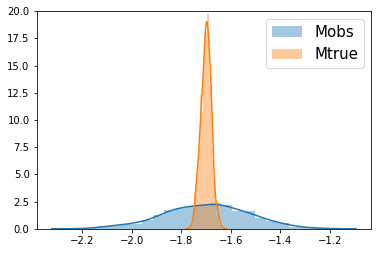

In [23]:
npts = 1000
rmu = -1.7
rsig = .02
runc = .1 #fractional uncertainty

Mtrue = np.random.randn(npts)*rsig + rmu
Munc = np.abs(Mtrue*runc)
Mobs = Mtrue + np.random.randn(npts)*Munc


sns.distplot(Mobs, label='Mobs')
sns.distplot(Mtrue, label='Mtrue')
plt.legend(fontsize=15)
plt.show()

Lets compare our likelihood to our posteriors

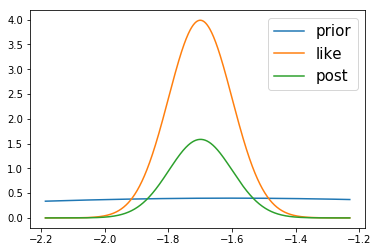

Median prior:-1.6100236877638627
Median like:-1.70020546709853
Median post:-1.6992460864673102


In [24]:
x = np.linspace(Mobs.min(), Mobs.max(), 1000)
li = normal(x, rmu, runc)
pr = normal(x, -1.61, 1.)
plt.plot(x, pr, label='prior')
plt.plot(x, li, label='like')
plt.plot(x, li*pr, label='post')
plt.legend(fontsize=15)
plt.show()
print('Median prior:' +str(x[np.argmax(pr)]))
print('Median like:' +str(x[np.argmax(li)]))
print('Median post:' +str(x[np.argmax(li*pr)]))

In [25]:
model = '''
data{
    int<lower=0> N;
    real Mobs[N];
    real Munc[N];
}
parameters{
    real mu;
    real<lower=0.> sigma;
    real Mtrue_std[N];
}
transformed parameters{
    real Mtrue[N];
    
    for (n in 1:N)
        Mtrue[n] = mu  + sigma*Mtrue_std[n];
}
model{
    mu ~ normal(-1.61, 1.);
    sigma ~ normal(0., .05);

    Mobs ~ normal(Mtrue, Munc);
    Mtrue_std ~ normal(0, 1);
}
'''
sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_31310cb00e0fa2bc79d5aa8a37c43866 NOW.


In [31]:
data = {'N': npts,
       'Mobs':Mobs,
       'Munc':Munc}
init = {'mu':rmu,
       'sigma':rsig}

fit = sm.sampling(data=data, iter=10000, chains=2, init=[init, init])


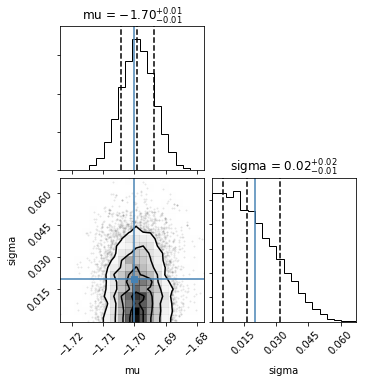

In [32]:
import corner
chain = np.array([fit['mu'],fit['sigma']]).T
truths=[rmu, rsig]
corner.corner(chain,labels=['mu','sigma'],\
                  truths=truths,\
                  quantiles=[0.16, 0.5, 0.84],\
                  show_titles=True, title_kwargs={"fontsize": 12})
plt.show()

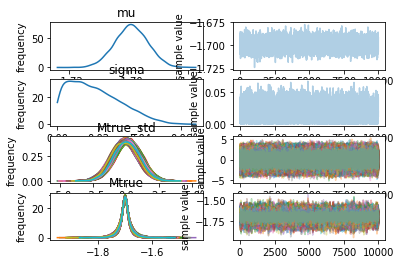

In [33]:
fit.plot()
plt.show()

In [34]:
print(fit)

Inference for Stan model: anon_model_31310cb00e0fa2bc79d5aa8a37c43866.
2 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=10000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu               -1.7  5.5e-5 5.5e-3  -1.71   -1.7   -1.7   -1.7  -1.69  10000    1.0
sigma            0.02  2.8e-4   0.01 7.3e-4 7.9e-3   0.02   0.03   0.05 2017.0    1.0
Mtrue_std[0]     0.17    0.01   1.01  -1.82   -0.5   0.18   0.84   2.15  10000    1.0
Mtrue_std[1]     0.09    0.01    1.0  -1.88   -0.6   0.08   0.77   2.08  10000    1.0
Mtrue_std[2]    -0.03  9.8e-3   0.98  -1.93   -0.7  -0.05   0.61   1.91  10000    1.0
Mtrue_std[3]     0.18  9.9e-3   0.99  -1.77  -0.48   0.18   0.86   2.12  10000    1.0
Mtrue_std[4]    -0.22  9.9e-3   0.99  -2.15  -0.89  -0.22   0.45   1.71  10000    1.0
Mtrue_std[5]    -0.14    0.01    1.0  -2.12   -0.8  -0.14   0.52   1.84  10000    1.0
Mtrue_std[6]    -0.22    0.01    1.

In [35]:
sys.exit()

NameError: name 'sys' is not defined

# Hierarchical Mixture Model

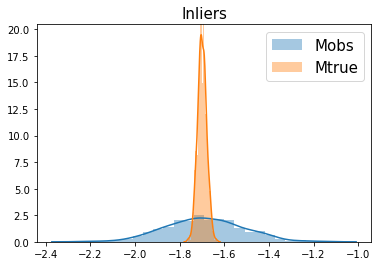

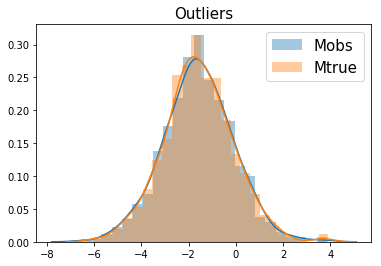

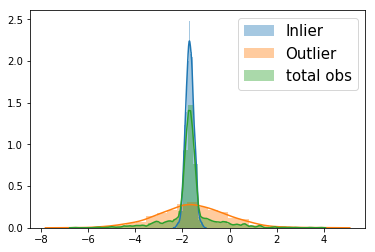

In [20]:
npts = 1000
rmu = -1.7
rsig = .02
runc = .1 #fractional uncertainty

iMtrue = np.random.randn(npts)*rsig + rmu
iMunc = np.abs(iMtrue*runc)
iMobs = iMtrue + np.random.randn(npts)*iMunc

sns.distplot(iMobs, label='Mobs')
sns.distplot(iMtrue, label='Mtrue')
plt.title('Inliers', fontsize=15)
plt.legend(fontsize=15)
plt.show()

rQ = .6
rmuo = rmu
rsigo = 1.5
onpts = int(npts*rQ)

oMtrue = np.random.randn(onpts)*rsigo + rmuo
oMunc = np.abs(oMtrue*runc)
oMobs = oMtrue + np.random.randn(onpts)*oMunc

sns.distplot(oMobs, label='Mobs')
sns.distplot(oMtrue, label='Mtrue')
plt.title('Outliers', fontsize=15)
plt.legend(fontsize=15)
plt.show()

Mobs = np.append(iMobs, oMobs)
Munc = np.append(iMunc, oMunc)

sns.distplot(iMobs, label='Inlier')
sns.distplot(oMobs, label='Outlier')
sns.distplot(Mobs, label='total obs')
plt.legend(fontsize=15)
plt.show()

In [10]:
model = '''
data{
    int<lower=0> N;
    real Mobs[N];
    real Munc[N];
}
parameters{
    real mu;
    real<lower=0.> sigma;
    real<lower=.3> sigo;
    real Mtrue_std[N];
    real<lower=0, upper=1.> Q;
}
transformed parameters{
    real Mtrue[N];
    real transformed_sigmao;
    
    for (n in 1:N)
        Mtrue[n] = mu + sigma * Mtrue_std[n];
    transformed_sigmao = sigo/sigma;
}
model{
    mu ~ normal(-1.61, .1);
    sigma ~ normal(.1, .05);
    sigo ~ normal(1.5, .5);

    Mobs ~ normal(Mtrue, Munc);
    for (n in 1:N)
        target += log_mix(Q,
                normal_lpdf(Mtrue_std | 0, 1),
                normal_lpdf(Mtrue_std | 0, transformed_sigmao));

}
'''
sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ac12530b495987ad60ae394d4461c5cb NOW.


In [14]:
npts+onpts
len(Munc)

1600

In [ ]:
data = {'N': npts+onpts,
       'Mobs':Mobs,
       'Munc':Munc}
init = {'mu':rmu,
       'sigma':rsig,
        'sigo':rsigo,
       'Q':rQ}

fit = sm.sampling(data=data, iter=2000, chains=2, init=[init, init])

In [ ]:
import corner
chain = np.array([fit['mu'],fit['sigma'],fit['Q'],fit['sigo']]).T
truths=[rmu, rsig, rQ, rsigo]
corner.corner(chain,labels=['mu','sigma','Q','sigo'],\
                  truths=truths,\
                  quantiles=[0.16, 0.5, 0.84],\
                  show_titles=True, title_kwargs={"fontsize": 12})
plt.show()

In [ ]:
fit.plot()
plt.show()

In [ ]:
print(fit)